Loan prediction practice problem

Problem description:

Company wants to automate the loan eligibility process (real time) based on customer detail provided
while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents,
Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the 
customers segments, those are eligible for loan amount so that they can specifically target these customers.Here they have provided a partial data set.

Date: March 03, 2017

Part 1: Data exploration and data check:

In [78]:
import pandas as pd
import numpy as np
import pylab as pl
#import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score,auc

In [77]:
data=pd.read_csv('train_data.csv')
display(data.head(1))
print "Training dataset has {} samples with {} features.".format(*data.shape)

train_features=data.drop(['Loan_Status'],1)
train_labels=data['Loan_Status']

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


Training dataset has 614 samples with 13 features.


In [79]:
#Import test data
test=pd.read_csv('test_data.csv')
test.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban


Step 1: Data exploration:
Check file content; 
For numeric variable check descriptive statistics; 
For categorical variables check frequence counts;
Check missing values for all variables; 

In [80]:
data.dtypes 

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [81]:
data.describe()#descriptive statistics for numeric variables
#Note: credit history is a binary variable;Loan_Amount_Term has a few values

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [83]:
#Check frequency of categorical variables
print pd.value_counts(data['Loan_Amount_Term'])
print pd.value_counts(data['Credit_History'])
print pd.value_counts(data['Gender'])
print pd.value_counts(data['Married'])
print pd.value_counts(data['Dependents']) 
print pd.value_counts(data['Education']) 
print pd.value_counts(data['Self_Employed']) 
print pd.value_counts(data['Property_Area']) 
print pd.value_counts(data['Loan_Status']) 

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64
1.0    475
0.0     89
Name: Credit_History, dtype: int64
Male      489
Female    112
Name: Gender, dtype: int64
Yes    398
No     213
Name: Married, dtype: int64
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
No     500
Yes     82
Name: Self_Employed, dtype: int64
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Y    422
N    192
Name: Loan_Status, dtype: int64


In [84]:
#Check if Loan_ID is unique for each row.
duplicates=data[data.duplicated(['Loan_ID'],keep=False)]
print duplicates.shape

(0, 13)


In [85]:
#Check missing values for all variables
def num_missing(x):
    return sum(x.isnull())
data.apply(num_missing,axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Initial investigation of the importance of each feature:

(1) Stacked histogram and chi-square test between Loan_status and categorical variables, such as gender, credit_history etc.

(2) Boxplot and T-TEST for Loan_Status vs. Continous variables(ApplicatIncome, Loan_Amount etc.)

In [86]:
from scipy.stats import chi2_contingency

# display the frequency table for each discrete variable, calculate chi2 statistics
def examine_discrete_vars (data, target, examvars):
         
    for idx, var in enumerate(examvars):
        
        print pd.crosstab(data[var], data[target],margins=True)
        p = chi2_contingency(pd.crosstab(data[var], data[target]))[1]
        print "P-value of chi2 test on", var, "is", p, "\n"

examine_discrete_vars (data, 'Loan_Status', ['Gender','Married','Credit_History','Dependents','Education','Self_Employed','Property_Area'])

Loan_Status    N    Y  All
Gender                    
Female        37   75  112
Male         150  339  489
All          192  422  614
P-value of chi2 test on Gender is 0.708652981645 

Loan_Status    N    Y  All
Married                   
No            79  134  213
Yes          113  285  398
All          192  422  614
P-value of chi2 test on Married is 0.0343938130158 

Loan_Status       N    Y  All
Credit_History               
0.0              82    7   89
1.0              97  378  475
All             192  422  614
P-value of chi2 test on Credit_History is 7.18475954875e-40 

Loan_Status    N    Y  All
Dependents                
0            107  238  345
1             36   66  102
2             25   76  101
3+            18   33   51
All          192  422  614
P-value of chi2 test on Dependents is 0.367850674086 

Loan_Status     N    Y  All
Education                  
Graduate      140  340  480
Not Graduate   52   82  134
All           192  422  614
P-value of chi2 test on Educat

Loan_Status
N    5446.078125
Y    5384.068720
Name: ApplicantIncome, dtype: float64
P-value of T-test on ApplicantIncome is 0.907287812131 

Loan_Status
N    1877.807292
Y    1504.516398
Name: CoapplicantIncome, dtype: float64
P-value of T-test on CoapplicantIncome is 0.142948286843 

Loan_Status
N    151.220994
Y    144.294404
Name: LoanAmount, dtype: float64
P-value of T-test on LoanAmount is 0.364736247911 



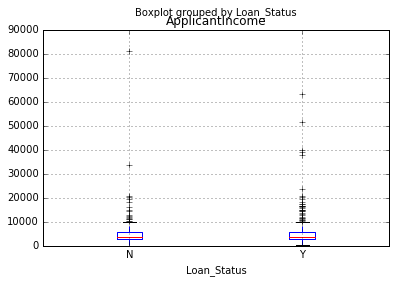

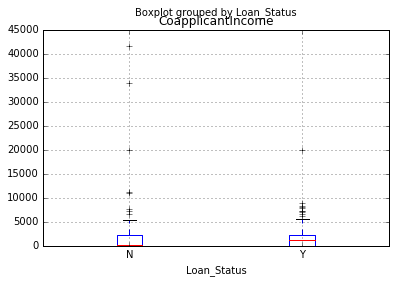

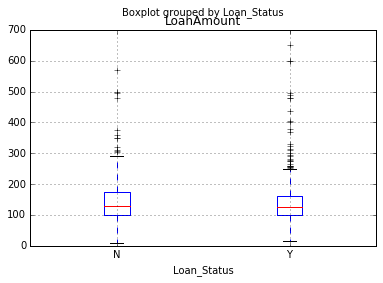

In [87]:
from scipy.stats import ttest_ind

def examine_continous_vars (data, target, examvars):
         
    for idx, var in enumerate(examvars):
        data.boxplot(column=var,by=target)
        rvs1=data.loc[data[target]=='N',var]
        rvs2=data.loc[data[target]=='Y',var]
        print data.groupby([target])[var].mean()
        p =ttest_ind(rvs1,rvs2,nan_policy='omit')[1]
        print "P-value of T-test on", var, "is", p, "\n"

examine_continous_vars (data, 'Loan_Status', ['ApplicantIncome','CoapplicantIncome','LoanAmount'])